### Implementation of M/M/n queue system

In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from joblib import Parallel, delayed

In [2]:
class Request:
    """Represents a single request in a M/M/n queue"""
    def __init__(self, request_id, arrival_time, service_time):
        self.request_id = request_id
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.wait_time = None

    def log_wait(self, wait_time):
        """Log waiting time"""
        self.wait_time = wait_time

# Generate service times using np.random.choice
def generate_service_time(probabilities, scales):
    choice = np.random.choice(len(probabilities), p=probabilities)
    return np.random.exponential(scale=1/scales[choice])

In [3]:
class MMNqueue:
    """Simulates an M/M/n queue."""
    def __init__(self, simpy_env, num_servers, service_probabilities, service_scales, num_requests, arrival_rate, scheduler_type="FIFO"):
        self.env = simpy_env
        self.num_servers = num_servers
        self.service_probabilities = service_probabilities
        self.service_scales = service_scales
        self.arrival_rate = arrival_rate

        match scheduler_type:
            case "FIFO" : self.pool = simpy.Resource(self.env, capacity=num_servers)
            case "SJF"  : self.pool = simpy.PriorityResource(self.env, capacity=num_servers)

        # Request information
        self.completed_requests = 0
        self.requests = []
        self.num_requests = num_requests

    def generate_request(self, request_id):
        """Generate a new request."""
        return Request(request_id, self.env.now, generate_service_time(self.service_probabilities, self.service_scales))

    def handle_request(self, request):
        """Handle requests using the selected resource (FIFO or SJF)."""
        if isinstance(self.pool, simpy.PriorityResource):
            # SJF: Use priority based on service time
            with self.pool.request(priority=request.service_time) as req:
                yield req
                request.log_wait(self.env.now - request.arrival_time)
                yield self.env.timeout(request.service_time)

            self.requests.append(request)  # Store the processed request
            self.completed_requests += 1
        else:
            # FIFO: No priority, just use FIFO
            with self.pool.request() as req:
                yield req
                request.log_wait(self.env.now - request.arrival_time)
                yield self.env.timeout(request.service_time)

            self.requests.append(request)  # Store the processed request
            self.completed_requests += 1

    def arrival_process(self):
        """Simulate the arrival process of requests."""
        request_id = 0
        while self.completed_requests < self.num_requests:
            yield self.env.timeout(np.random.exponential(1 / self.arrival_rate))  # Inter-arrival time
            request = self.generate_request(request_id)
            request_id += 1
            # Add request to the appropriate resource queue (based on FIFO/SJF)
            self.env.process(self.handle_request(request))  # Process the request


In [4]:
class MDNqueue(MMNqueue):
    def __init__(self, simpy_env, num_servers, num_requests, D, arrival_rate, scheduler_type="FIFO"):
        self.env = simpy_env
        self.num_servers = num_servers
        self.D = 1/D
        self.arrival_rate = arrival_rate

        match scheduler_type:
            case "FIFO" : self.pool = simpy.Resource(self.env, capacity=num_servers)
            case "SJF"  : self.pool = simpy.PriorityResource(self.env, capacity=num_servers)

        # Request information
        self.completed_requests = 0
        self.requests = []
        self.num_requests = num_requests

    def generate_request(self, request_id):
        """Generate a new request."""
        return Request(request_id, self.env.now, 1/self.D)


In [5]:
def run_simulation(num_requests, num_servers, arrival_rate, D=None, service_probabilities=None, service_scales=None, scheduler_type="FIFO", queue_type="MMN"):
    env = simpy.Environment()

    match queue_type:
        case "MMN" : queue_sim = MMNqueue(
            simpy_env=env,
            num_servers=num_servers,
            service_probabilities=service_probabilities,
            service_scales=service_scales,
            num_requests=num_requests,
            arrival_rate=arrival_rate,
            scheduler_type=scheduler_type,
        )
        case "MDN" : queue_sim = MDNqueue(
            simpy_env=env,
            num_servers=num_servers,
            D=D,
            num_requests=num_requests,
            arrival_rate=arrival_rate,
            scheduler_type=scheduler_type,
        )

    env.process(queue_sim.arrival_process())

    env.run()

    wait_times = [req.wait_time for req in queue_sim.requests if req.wait_time is not None]
    service_times = [req.service_time for req in queue_sim.requests]

    return {
        "wait_times": wait_times,
        "service_times": service_times,
        "num_completed_requests": len(queue_sim.requests) if queue_type == "MDN" else len(queue_sim.requests),
        "num_total_requests": num_requests,
    }

In [ ]:
# n= 1  #quueues
# lamda = 0.2*n
# mu = 2/9  #=1/4.5
# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.factorial.html
# p_sum = 0
# for j in range(n):
#     p_sum+=1/(sp.special.factorial(j, exact=True))  * (lamda/mu)**j
# p_sum += 1/(sp.special.factorial(n, exact=True))* (mu*n/(mu*n - lamda))*(lamda/mu)**n
# P_0 = 1/p_sum

# W = 1/(sp.special.factorial(n-1, exact=True))*(lamda * mu / (n*mu - lamda)**2)*(lamda/mu)**n
# print(W*P_0/lamda)

40.50000000000005


In [ ]:
def calculate_theoretical_waiting_time(lamda = None, mu = None, n = 1, queue_type = "MMN"):
    match queue_type:
        case "MMN" :
            if n==1:
                return lamda / (mu**2 - lamda * mu)
            # elif n==2:
            #     return lamda**2 / (mu*(4*mu**2 - lamda**2))
            else:# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.factorial.html
                p_sum = 0
                for j in range(n):
                    p_sum+=1/(sp.special.factorial(j, exact=True))  * (lamda/mu)**j
                p_sum += 1/(sp.special.factorial(n, exact=True))* (mu*n/(mu*n - lamda))*(lamda/mu)**n
                P_0 = 1/p_sum

                Lq = P_0*(1/(sp.special.factorial(n-1, exact=True)))*(lamda * mu / (n*mu - lamda)**2)*(lamda/mu)**n
                W= Lq / lamda
                return W

        case "MDN" : return lamda / (2*mu * (n*mu - lamda))

In [7]:
# Parameters
num_requests = 100000
num_servers = 1
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [1]  # Example probabilities for different service times
service_scales = [1/4.5]  # Example service rates
D = 4.5
# print(service_scales[0])  = 0.222...
burn_in_percentage = 0.10
burn_in_count = int(num_requests * burn_in_percentage)
# print(calculate_theoretical_waiting_time(lamda = arrival_rate, mu =D, queue_type="MDn"))
# Run FIFO simulation (M/M/N)
fifo_result = run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type="FIFO", queue_type="MMN")
print(f'FIFO Results (M/M/N): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')
print(f'Theoretical Expectation under FIFO: {calculate_theoretical_waiting_time(lamda = arrival_rate, mu =service_scales[0], n = num_servers):.4f}')

# Run SJF simulation (M/M/N)
sjf_result = run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type="SJF", queue_type="MMN")
print(f'SJF Results (M/M/N): {np.mean(sjf_result["wait_times"][burn_in_count:]):.4f}')

# Run FIFO simulation (M/D/N)
fifo_result = run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, D=D, scheduler_type="FIFO", queue_type="MDN")
print(f'FIFO Results (M/D/N): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')
print(f'Theoretical Expectation under FIFO: {calculate_theoretical_waiting_time(lamda = arrival_rate, mu =D, queue_type="MDN"):.4f}')

# Run SJF simulation (M/D/N)
sjf_result = run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, D=D, scheduler_type="SJF", queue_type="MDN")
print(f'SJF Results (M/D/N): {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')



FIFO Results (M/M/N): 42.6216
Theoretical Expectation under FIFO: 40.5000
SJF Results (M/M/N): 13.6550
FIFO Results (M/D/N): 20.4992
Theoretical Expectation under FIFO: 0.0052
SJF Results (M/D/N): 20.4992


In [8]:
# Parameters
num_requests = 100000
num_servers = 1
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [0.75, 0.25]  # Example probabilities for different service times
service_scales = [1/1, 1/5]  # Example service rates

burn_in_percentage = 0.05
burn_in_count = int(num_requests * burn_in_percentage)

# Run FIFO simulation
fifo_result = run_simulation(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO")
print(f'FIFO Results: {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}')

ValueError: probabilities do not sum to 1

In [ ]:
# Parameters
num_requests = 100000
num_servers = 2
arrival_rate = 1/5  # Inter-arrival time
D = 4

burn_in_percentage = 0.10
burn_in_count = int(num_requests * burn_in_percentage)

# Run FIFO simulation
fifo_result = run_simulation_MDN(num_requests, num_servers, arrival_rate, D, scheduler_type="FIFO")
print(f"FIFO Results: {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}")

# Run SJF simulation
sjf_result = run_simulation_MDN(num_requests, num_servers, arrival_rate, D, scheduler_type="SJF")
print(f"SJF Results: {np.mean(sjf_result["wait_times"][burn_in_count:]):.4f}")


FIFO Results: 0.4136
SJF Results: 0.4246


#### Mutlithreading the code

We use JobLibs to run the simulations in parallel in order to save time / add more simulation. The parameter `n_jobs` is set to `-1`, meaning that all available cores on the user's computer are used. If you want to use, for instance, 4 out of 8 cores, set `n_jobs = 4`.

In [9]:
def simulation_wrapper_MMN(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type, queue_type):
    return run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, service_probabilities= service_probabilities, service_scales = service_scales, scheduler_type=scheduler_type, queue_type=queue_type)

def simulation_wrapper_MDN(num_requests, num_servers, arrival_rate, D, scheduler_type, queue_type):
    return run_simulation(num_requests=num_requests, num_servers=num_servers, arrival_rate=arrival_rate, D=D, scheduler_type=scheduler_type, queue_type=queue_type)

def simulate_parallel(n_runs, num_requests, num_servers, arrival_rate, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MMN"):
    match queue_type:
        case "MMN" : return Parallel(n_jobs=2)(delayed(simulation_wrapper_MMN)(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type=scheduler_type, queue_type=queue_type) for _ in range(n_runs))
        case "MDN" : return Parallel(n_jobs=2)(delayed(simulation_wrapper_MDN)(num_requests, num_servers, arrival_rate, D, scheduler_type=scheduler_type, queue_type=queue_type) for _ in range(n_runs))

The cell below calculates the statistics for the simlated queues. Such as the mean of the samples, the $\chi^2$, and the p-value.

In [10]:
def calc_statistics(means, stds, arrival_rate, service_rate, num_servers, num_simulations, queue_type):
    E_theo = calculate_theoretical_waiting_time(arrival_rate, service_rate, num_servers, queue_type)
    exp_mean = np.mean(means)
    conf95 = 1.96*stds/np.sqrt(num_simulations)
    chi_squared = np.sum((means-E_theo)**2 / conf95**2)
    critical_value = sp.stats.chi2.ppf(0.95, num_simulations - 1)
    p_value = 1 - sp.stats.chi2.cdf(chi_squared, num_simulations - 1)

    return [E_theo, exp_mean, conf95, chi_squared, critical_value, p_value]

In [11]:
# Set general parameters for the simulations:
num_requests = 500000
num_servers = [1, 2, 4]
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [1]  # Example probabilities for different service times
service_scales = [1/4.5]  # Example service rates
D = 4.5
burn_in_percentage = 0.1
burn_in_count = int(num_requests * burn_in_percentage)
num_simulations = 100
x_axis_plots = range(1, num_simulations+1)

#### Simulating FIFO and SJF scheduling for comparison

We simulate the queues for $n = 1, 2, 4$ servers and extract the waiting times of the simulations. We will compare the results to the theoretical value for the waiting time and the $\chi^2$ is calculated using `calculate_statistics` to determine whether our result is statistically significant. In the case of SJF, there is no theoretical value that we can use for reference, we can only compare the mean of the measurements to the mean of FIFO.

In [12]:
sim_means_fifo = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    fifo_result = simulate_parallel(num_simulations, num_requests, n, arrival_rate*n, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MMN")

    for i in range(num_simulations):
        sim_means_fifo[j, i] = np.mean(fifo_result[i]["wait_times"][burn_in_count:])
        sim_stds_fifo[j ,i] = np.std(fifo_result[i]["wait_times"][burn_in_count:])

In [15]:
fifo_single_server_stats = calc_statistics(sim_means_fifo[0], sim_stds_fifo[0], arrival_rate, service_scales[0], 1, num_simulations, "MMN")
fifo_two_server_stats = calc_statistics(sim_means_fifo[1], sim_stds_fifo[1], arrival_rate, service_scales[0], 2, num_simulations, "MMN")
fifo_four_server_stats = calc_statistics(sim_means_fifo[2], sim_stds_fifo[2], arrival_rate, service_scales[0], 4, num_simulations, "MMN")

In [ ]:
sim_means_sjf = np.zeros((len(num_servers), num_simulations))
sim_stds_sjf = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    sjf_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="SJF", queue_type="MMN")

    for i in range(num_simulations):
        sim_means_sjf[j, i] = np.mean(sjf_result[i]["wait_times"][burn_in_count:])
        sim_stds_sjf[j ,i] = np.std(sjf_result[i]["wait_times"][burn_in_count:])

In [25]:
sjf_single_server_mean = np.mean(sim_means_sjf[0])
sjf_single_conf95 = 1.96 * sim_stds_sjf[0] / np.sqrt(num_simulations)
sjf_two_server_mean = np.mean(sim_means_sjf[1])
sjf_two_conf95 = 1.96 * sim_stds_sjf[1] / np.sqrt(num_simulations)
sjf_four_server_mean = np.mean(sim_means_sjf[2])
sjf_four_conf95 = 1.96 * sim_stds_sjf[2] / np.sqrt(num_simulations)

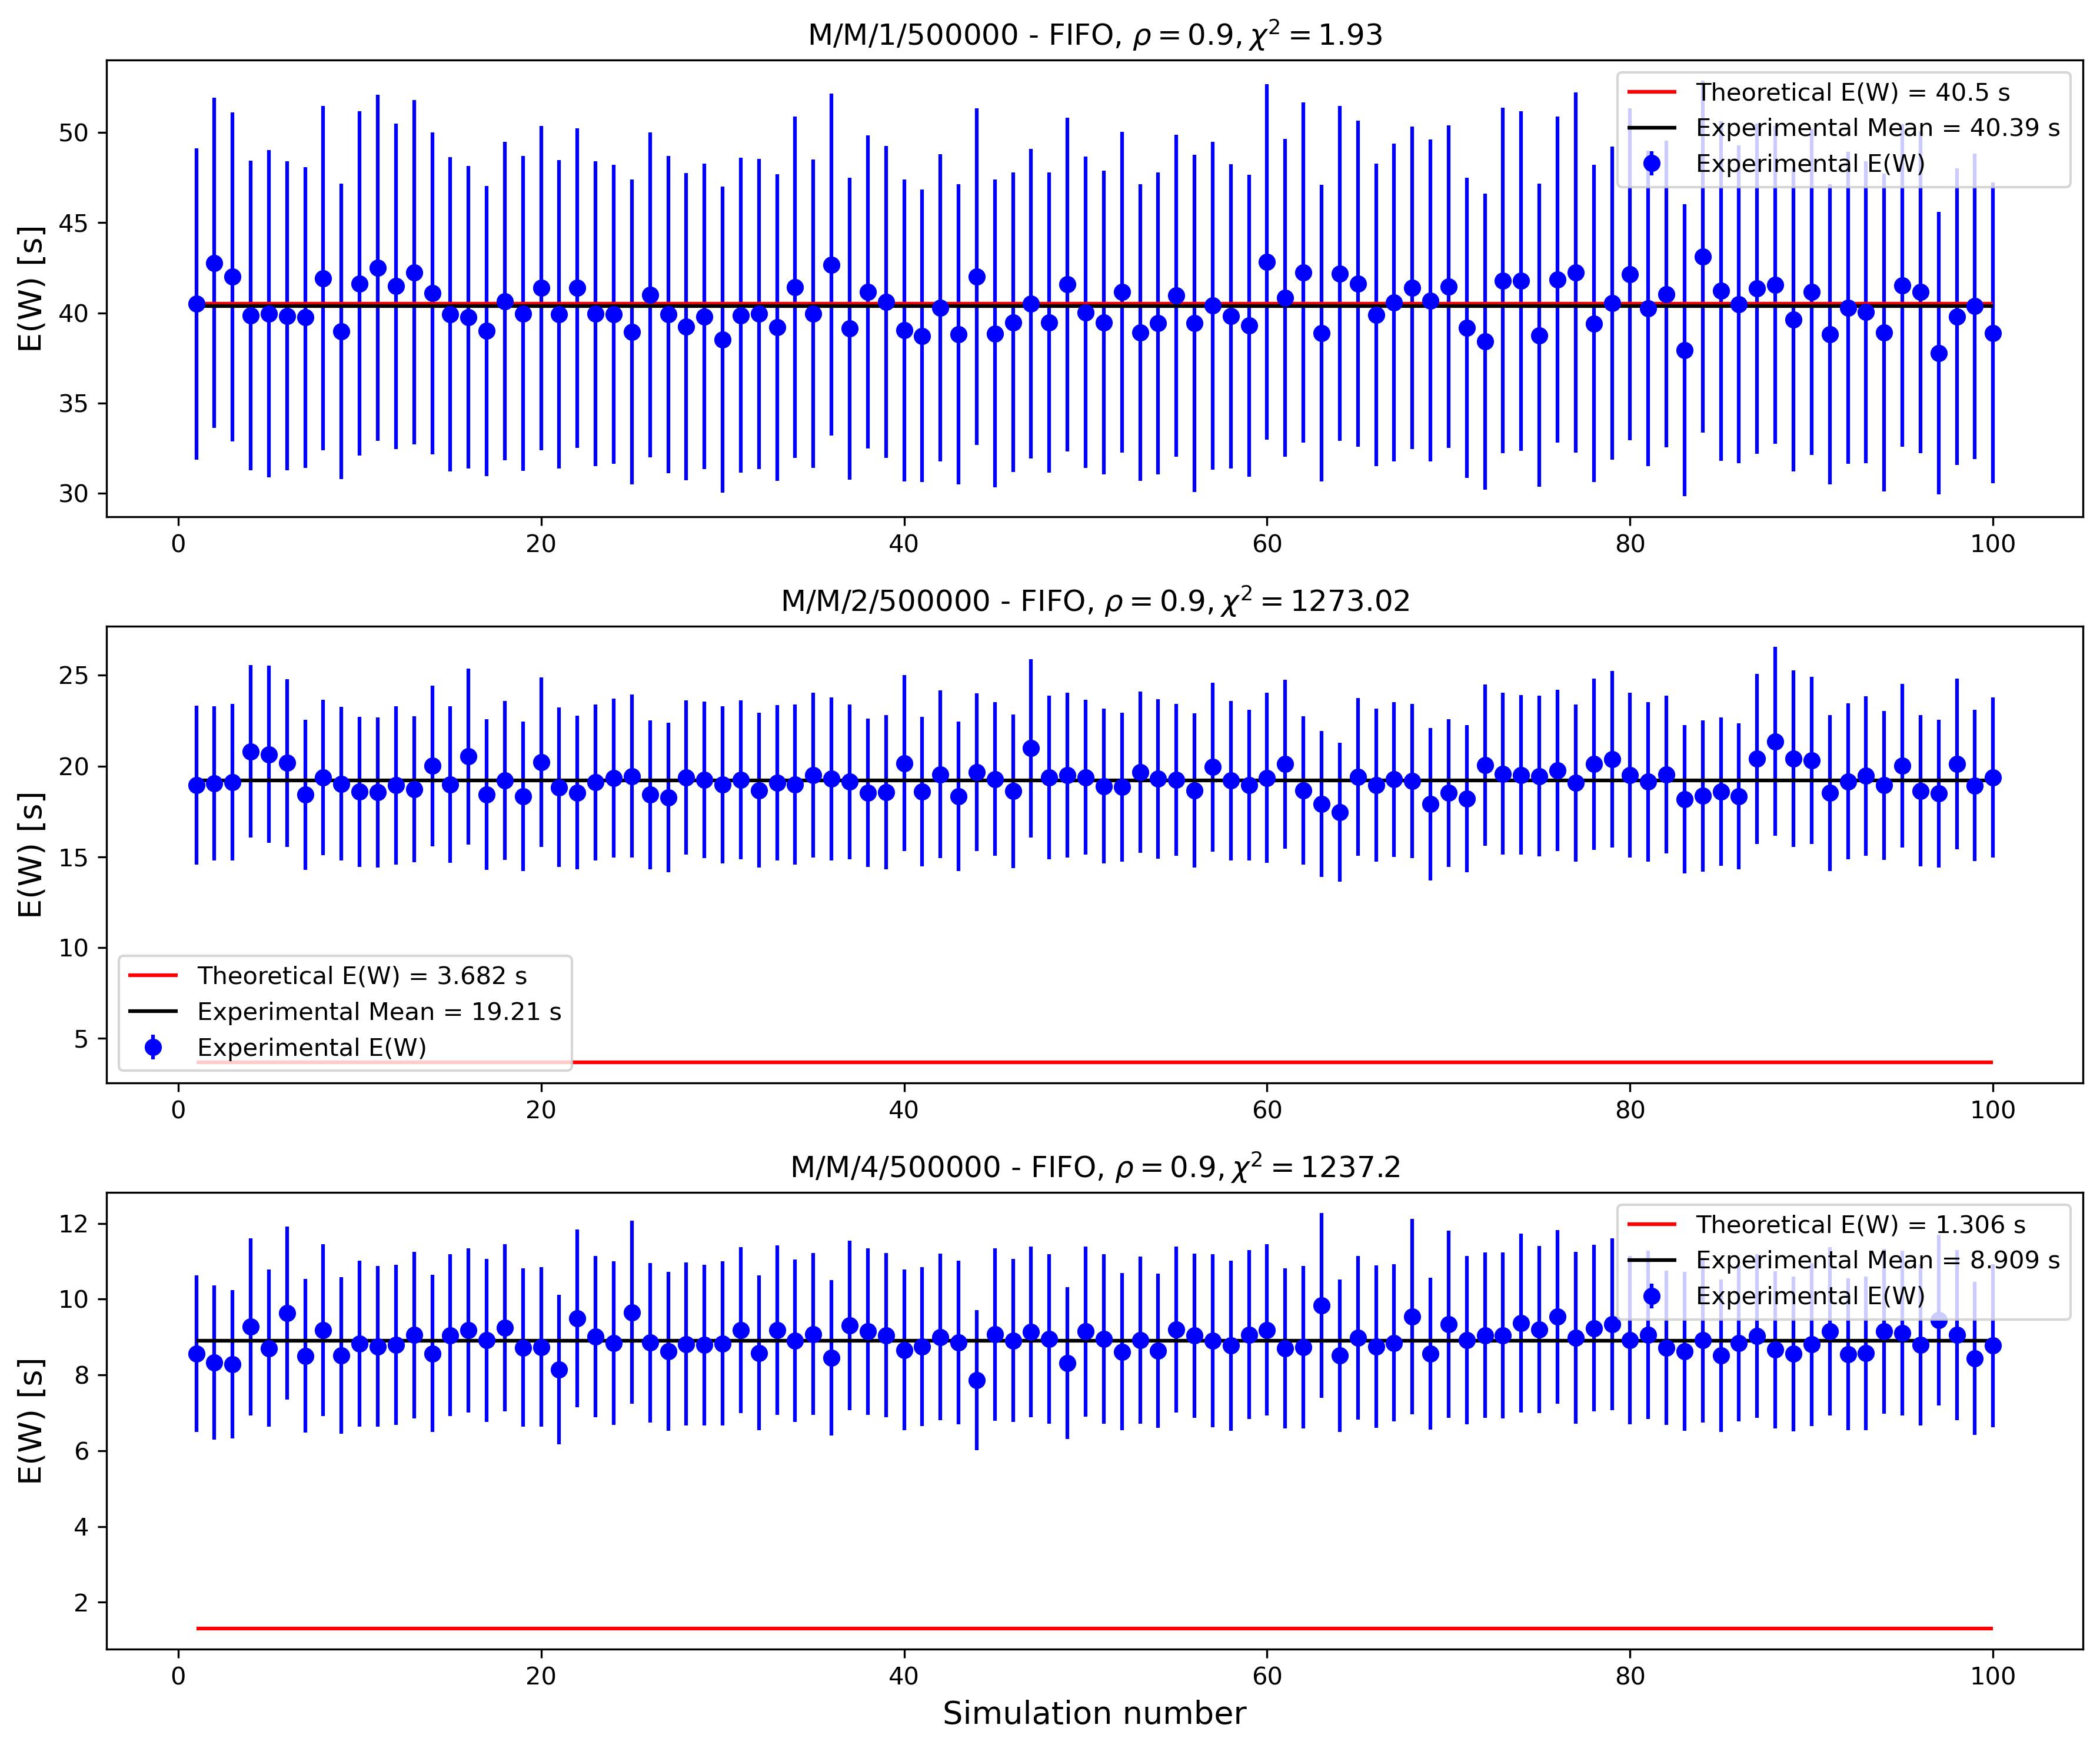

In [ ]:
plt.figure(figsize=(12, 10), dpi=300)

plt.subplot(3,1,1)
plt.title(fr'M/M/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/(num_servers[0]*service_scales[0]), 2)}}}, \chi^2 = {round(fifo_single_server_stats[3], 2)}$')
plt.errorbar(range(1, num_simulations+1), sim_means_fifo[0], yerr=fifo_single_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
# plt.plot(x_axis_plots, sim_means_fifo[0], color='blue', label='Experimental E(W)')
# plt.fill_between(x_axis_plots, sim_means_fifo[0] - fifo_single_server_stats[2], sim_means_fifo[0] + fifo_single_server_stats[2], color='blue', alpha=0.5)
plt.hlines(fifo_single_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_single_server_stats[0], 3)} s')
plt.hlines(fifo_single_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,1,3)
plt.title(fr'M/M/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*service_scales[0]), 2)}}}, \chi^2 = {round(fifo_two_server_stats[3], 2)}$')
plt.errorbar(range(1, num_simulations+1), sim_means_fifo[1], yerr=fifo_two_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
# plt.plot(x_axis_plots, sim_means_fifo[1], color='blue', label='Experimental E(W)')
# plt.fill_between(x_axis_plots, sim_means_fifo[1] - fifo_two_server_stats[2], sim_means_fifo[1] + fifo_two_server_stats[2], color='blue', alpha=0.5)
plt.hlines(fifo_two_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_two_server_stats[0], 3)} s')
plt.hlines(fifo_two_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_stats[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,1,5)
plt.title(fr'M/M/{num_servers[2]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[2]*arrival_rate/(num_servers[2]*service_scales[0]), 2)}}}, \chi^2 = {round(fifo_four_server_stats[3], 2)}$')
plt.errorbar(range(1, num_simulations+1), sim_means_fifo[2], yerr=fifo_four_server_stats[2], fmt = 'o', color='blue', label='Experimental E(W)')
# plt.plot(x_axis_plots, sim_means_fifo[2], color='blue', label='Experimental E(W)')
# plt.fill_between(x_axis_plots, sim_means_fifo[2] - fifo_four_server_stats[2], sim_means_fifo[2] + fifo_four_server_stats[2], color='blue', alpha=0.5)
plt.hlines(fifo_four_server_stats[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_four_server_stats[0], 3)} s')
plt.hlines(fifo_four_server_stats[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_four_server_stats[1], 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,2)
plt.title(fr'M/M/{num_servers[0]}/{num_requests} - SJF, $\rho = {{{round(arrival_rate/(num_servers[0]*service_scales[0]), 2)}}}$')
plt.errorbar(range(1, num_simulations+1), sim_means_sjf[0], yerr=sjf_single_conf95, fmt = 'o', color='blue', label='Experimental E(W)')
# plt.plot(x_axis_plots, sim_means_sjf[0], color='blue', label='Experimental E(W)')
# plt.fill_between(x_axis_plots, sim_means_sjf[0] - sjf_single_conf95, sim_means_sjf[0] + sjf_single_conf95, color='blue', alpha=0.5)
plt.hlines(sjf_single_server_mean, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_single_server_mean, 3)} s')
plt.legend()

plt.subplot(3,2,4)
plt.title(fr'M/M/{num_servers[1]}/{num_requests} - SJF, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*service_scales[0]), 2)}}}$')
plt.errorbar(range(1, num_simulations+1), sim_means_sjf[1], yerr=sjf_two_conf95, fmt = 'o', color='blue', label='Experimental E(W)')
# plt.plot(x_axis_plots, sim_means_sjf[1], color='blue', label='Experimental E(W)')
# plt.fill_between(x_axis_plots, sim_means_sjf[1] - sjf_two_conf95, sim_means_sjf[1] + sjf_two_conf95, color='blue', alpha=0.5)
plt.hlines(sjf_two_server_mean, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_two_server_mean, 3)} s')
plt.legend()

plt.subplot(3,2,6)
plt.title(fr'M/M/{num_servers[2]}/{num_requests} - SJF, $\rho = {{{round(num_servers[2]*arrival_rate/(num_servers[2]*service_scales[0]), 2)}}}$')
plt.errorbar(range(1, num_simulations+1), sim_means_sjf[2], yerr=sjf_four_conf95, fmt = 'o', color='blue', label='Experimental E(W)')
# plt.plot(x_axis_plots, sim_means_sjf[2], color='blue', label='Experimental E(W)')
# plt.fill_between(x_axis_plots, sim_means_sjf[2] - sjf_four_conf95, sim_means_sjf[2] + sjf_four_conf95, color='blue', alpha=0.5)
plt.hlines(sjf_four_server_mean, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_four_server_mean, 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)

plt.tight_layout()
plt.show()

#### Impact of number of simulations on statistical significance

We increase the parameter $\rho$ to nearly 1 (by increasing the $\lambda$ and keeping $\mu$ constant) to observe how the $\chi^2$ changes for a different number of simulations. If $\chi^2$ increases above its critical value, the result is no longer significant. This is done for an $M/M/1$ queue.

In [40]:
def Chi2_vs_rho(num_sim, num_requests, n_servers, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN"):

    chi_test_means = np.zeros((len(arr_rate_list),num_sim))
    chi_test_stds = np.zeros((len(arr_rate_list),num_sim))

    for i, rate in enumerate(arr_rate_list):
        chi_test = simulate_parallel(num_sim, num_requests, n_servers, rate, service_probabilities, service_scales, D, scheduler_type=scheduler_type, queue_type=queue_type)
        for j in range(num_sim):
            chi_test_means[i, j] = np.mean(chi_test[j]["wait_times"][burn_in_count:])
            chi_test_stds[i,j] = np.std(chi_test[j]["wait_times"][burn_in_count:])

    chis = []
    for i in range(len(arr_rate_list)):
        _, _, _, chisq, crit_val, _ = calc_statistics(chi_test_means[i], chi_test_stds[i], arr_rate_list[i], service_scales[0], 1, num_sim, "MMn")
        chis.append(chisq)

    return chis, crit_val

In [41]:
arr_rate_list = [1/5, 1/4.9, 1/4.8, 1/4.7, 1/4.6, 1/4.55]
rho = np.array(arr_rate_list) / service_scales[0]

chis_10, chi_10_crit = Chi2_vs_rho(10, 500000, 1, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN")
chis_50, chi_50_crit = Chi2_vs_rho(50, 500000, 1, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN")
chis_100, chi_100_crit = Chi2_vs_rho(100, 500000, 1, arr_rate_list, service_probabilities, service_scales, scheduler_type="FIFO", queue_type="MMN")

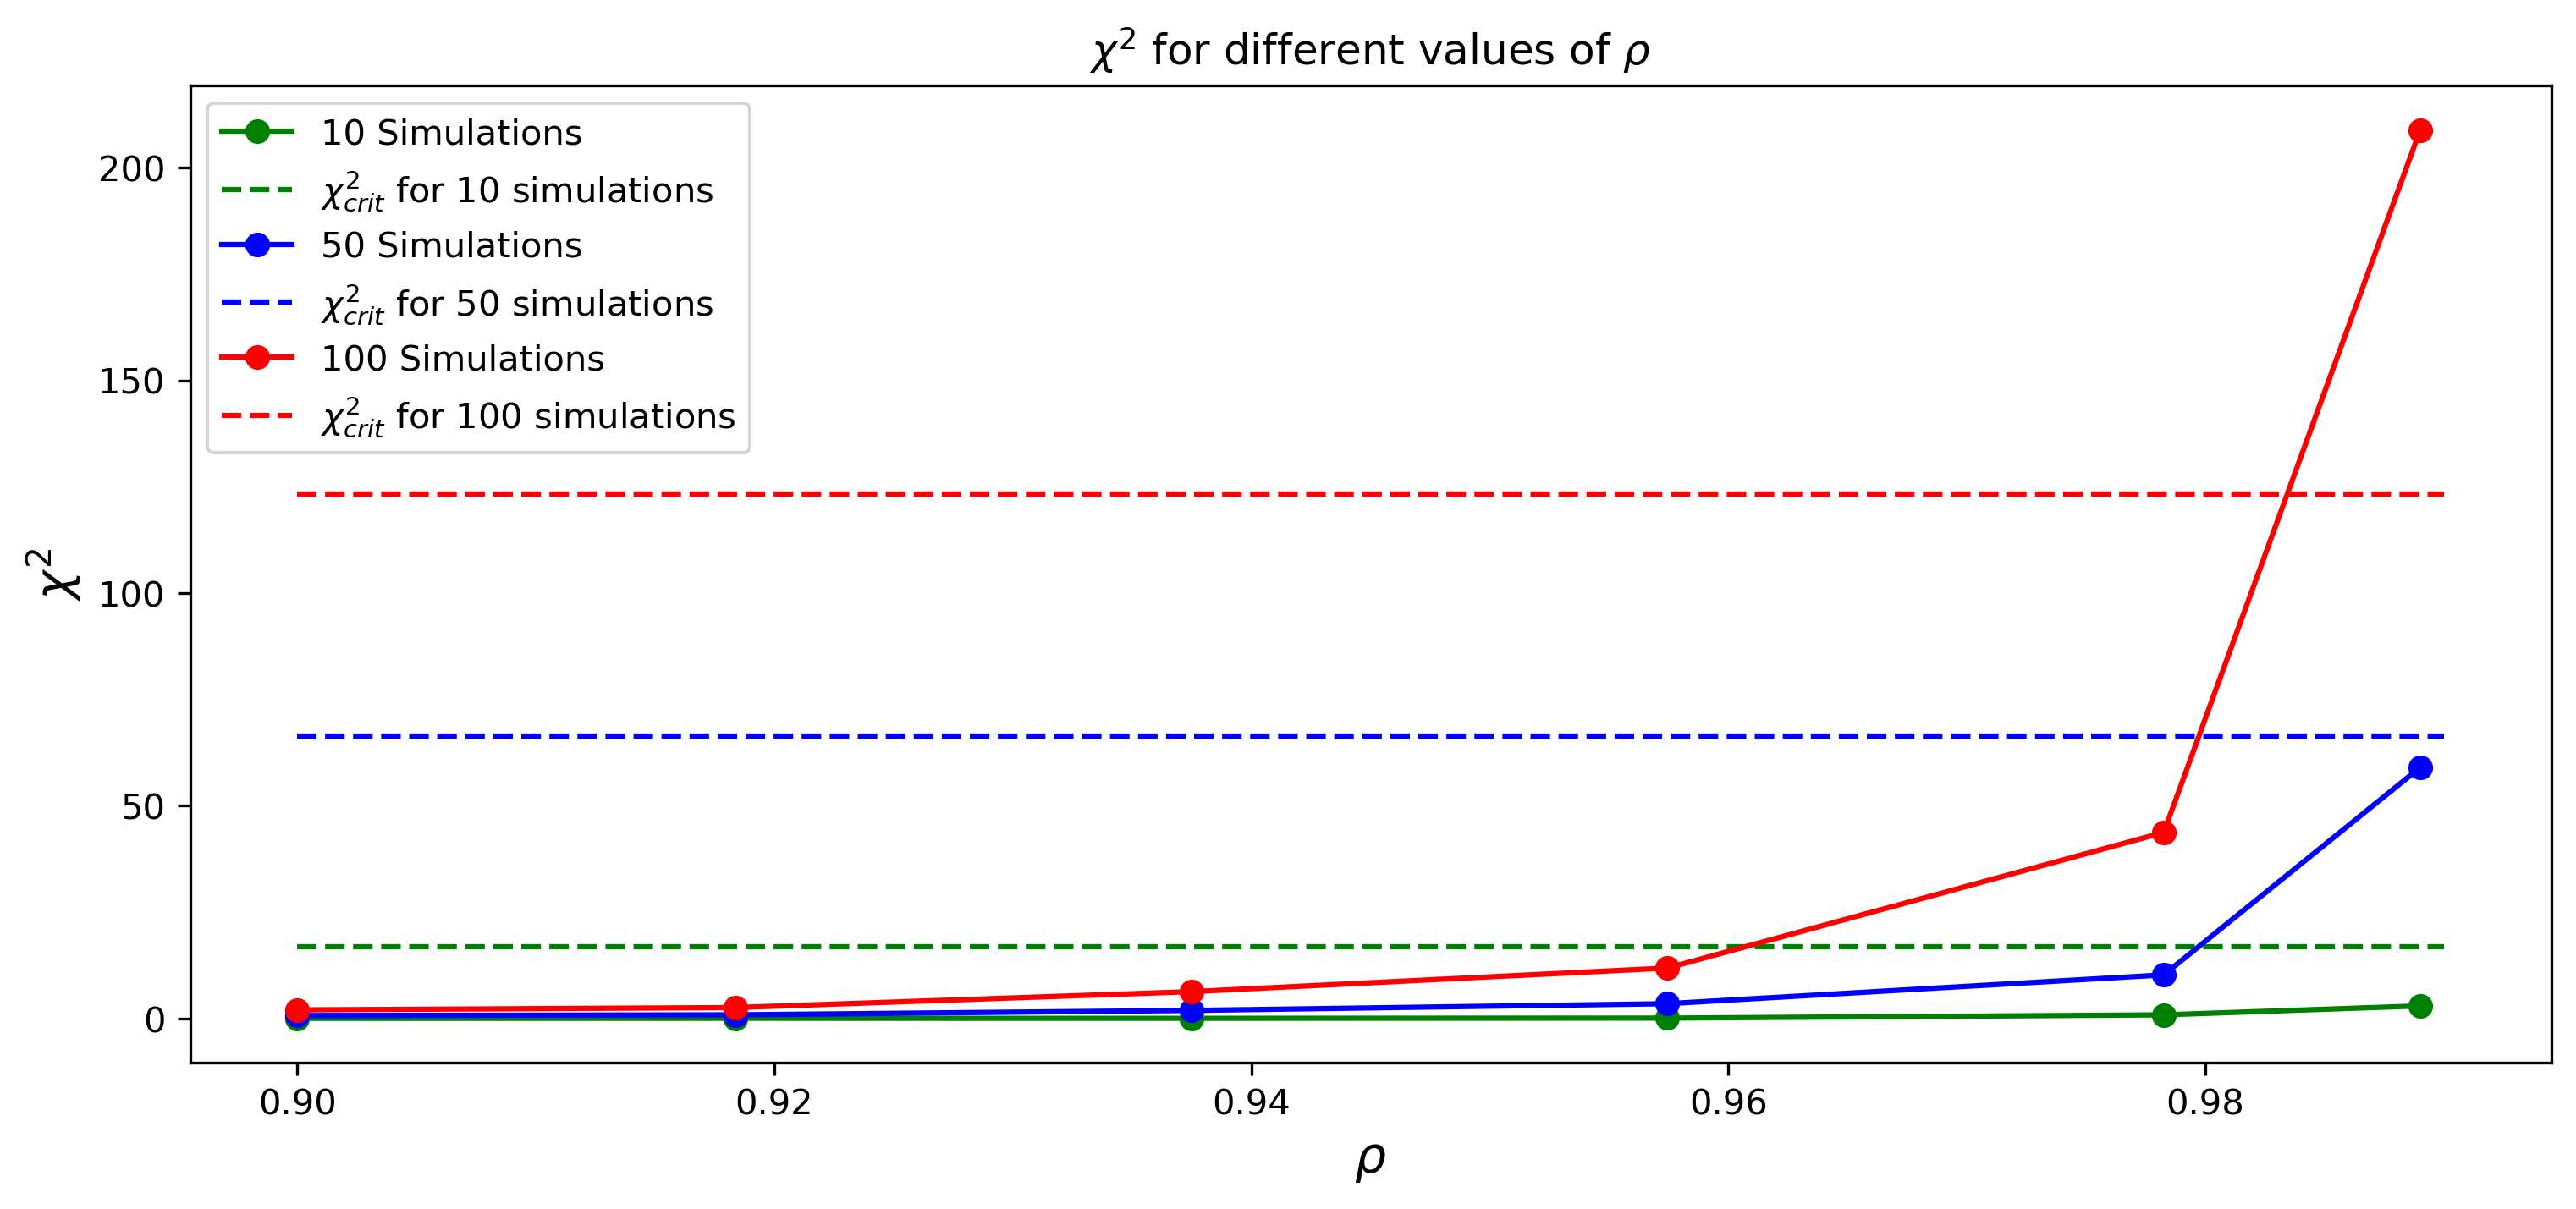

In [46]:
plt.figure(figsize=(12, 5), dpi=300)
plt.title(r'$\chi^2$ for different values of $\rho$')
plt.plot(rho, chis_10, color='green', marker='o', label='10 Simulations')
plt.hlines(chi_10_crit, xmin=0.9, xmax=0.99, color='green', ls='dashed', label=r'$\chi^2_{crit}$ for 10 simulations')
plt.plot(rho, chis_50, color='blue', marker='o', label='50 Simulations')
plt.hlines(chi_50_crit, xmin=0.9, xmax=0.99, color='blue', ls='dashed', label=r'$\chi^2_{crit}$ for 50 simulations')
plt.plot(rho, chis_100, color='red', marker='o', label='100 Simulations')
plt.hlines(chi_100_crit, xmin=0.9, xmax=0.99, color='red', ls='dashed', label=r'$\chi^2_{crit}$ for 100 simulations')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$\chi^2$', fontsize=14)
plt.legend()
plt.show()

#### Comparing FIFO and SJF for M/D/n

we now compare FIFO and SJF for queues with a different number of servers for a deterministic (constant) service time, D.

In [ ]:
sim_means_fifo_det = np.zeros((len(num_servers), num_simulations))
sim_stds_fifo_det = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    fifo_det_result = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="FIFO", queue_type="MDN")

    for i in range(num_simulations):
        sim_means_fifo_det[j, i] = np.mean(fifo_det_result[i]["wait_times"][burn_in_count:])
        sim_stds_fifo_det[j ,i] = np.std(fifo_det_result[i]["wait_times"][burn_in_count:])

In [32]:
fifo_single_server_stats_det = calc_statistics(sim_means_fifo_det[0], sim_stds_fifo_det[0], arrival_rate, 1/D, 1, num_simulations, "MDn")
fifo_two_server_stats_det = calc_statistics(sim_means_fifo_det[1], sim_stds_fifo_det[1], arrival_rate, 1/D, 2, num_simulations, "MDn")
fifo_four_server_stats_det = calc_statistics(sim_means_fifo_det[2], sim_stds_fifo_det[2], arrival_rate, 1/D, 4, num_simulations, "MDn")

In [ ]:
sim_means_sjf_det = np.zeros((len(num_servers), num_simulations))
sim_stds_sjf_det = np.zeros((len(num_servers), num_simulations))

for j, n in enumerate(num_servers):
    sjf_result_det = simulate_parallel(num_simulations, num_requests, n, n*arrival_rate, service_probabilities, service_scales, D, scheduler_type="SJF", queue_type="MDN")

    for i in range(num_simulations):
        sim_means_sjf_det[j, i] = np.mean(sjf_result_det[i]["wait_times"][burn_in_count:])
        sim_stds_sjf_det[j ,i] = np.std(sjf_result_det[i]["wait_times"][burn_in_count:])

In [34]:
sjf_single_server_mean_det = np.mean(sim_means_sjf_det[0])
sjf_single_conf95_det = 1.96 * sim_stds_sjf_det[0] / np.sqrt(num_simulations)
sjf_two_server_mean_det = np.mean(sim_means_sjf_det[1])
sjf_two_conf95_det = 1.96 * sim_stds_sjf_det[1] / np.sqrt(num_simulations)
sjf_four_server_mean_det = np.mean(sim_means_sjf_det[2])
sjf_four_conf95_det = 1.96 * sim_stds_sjf_det[2] / np.sqrt(num_simulations)

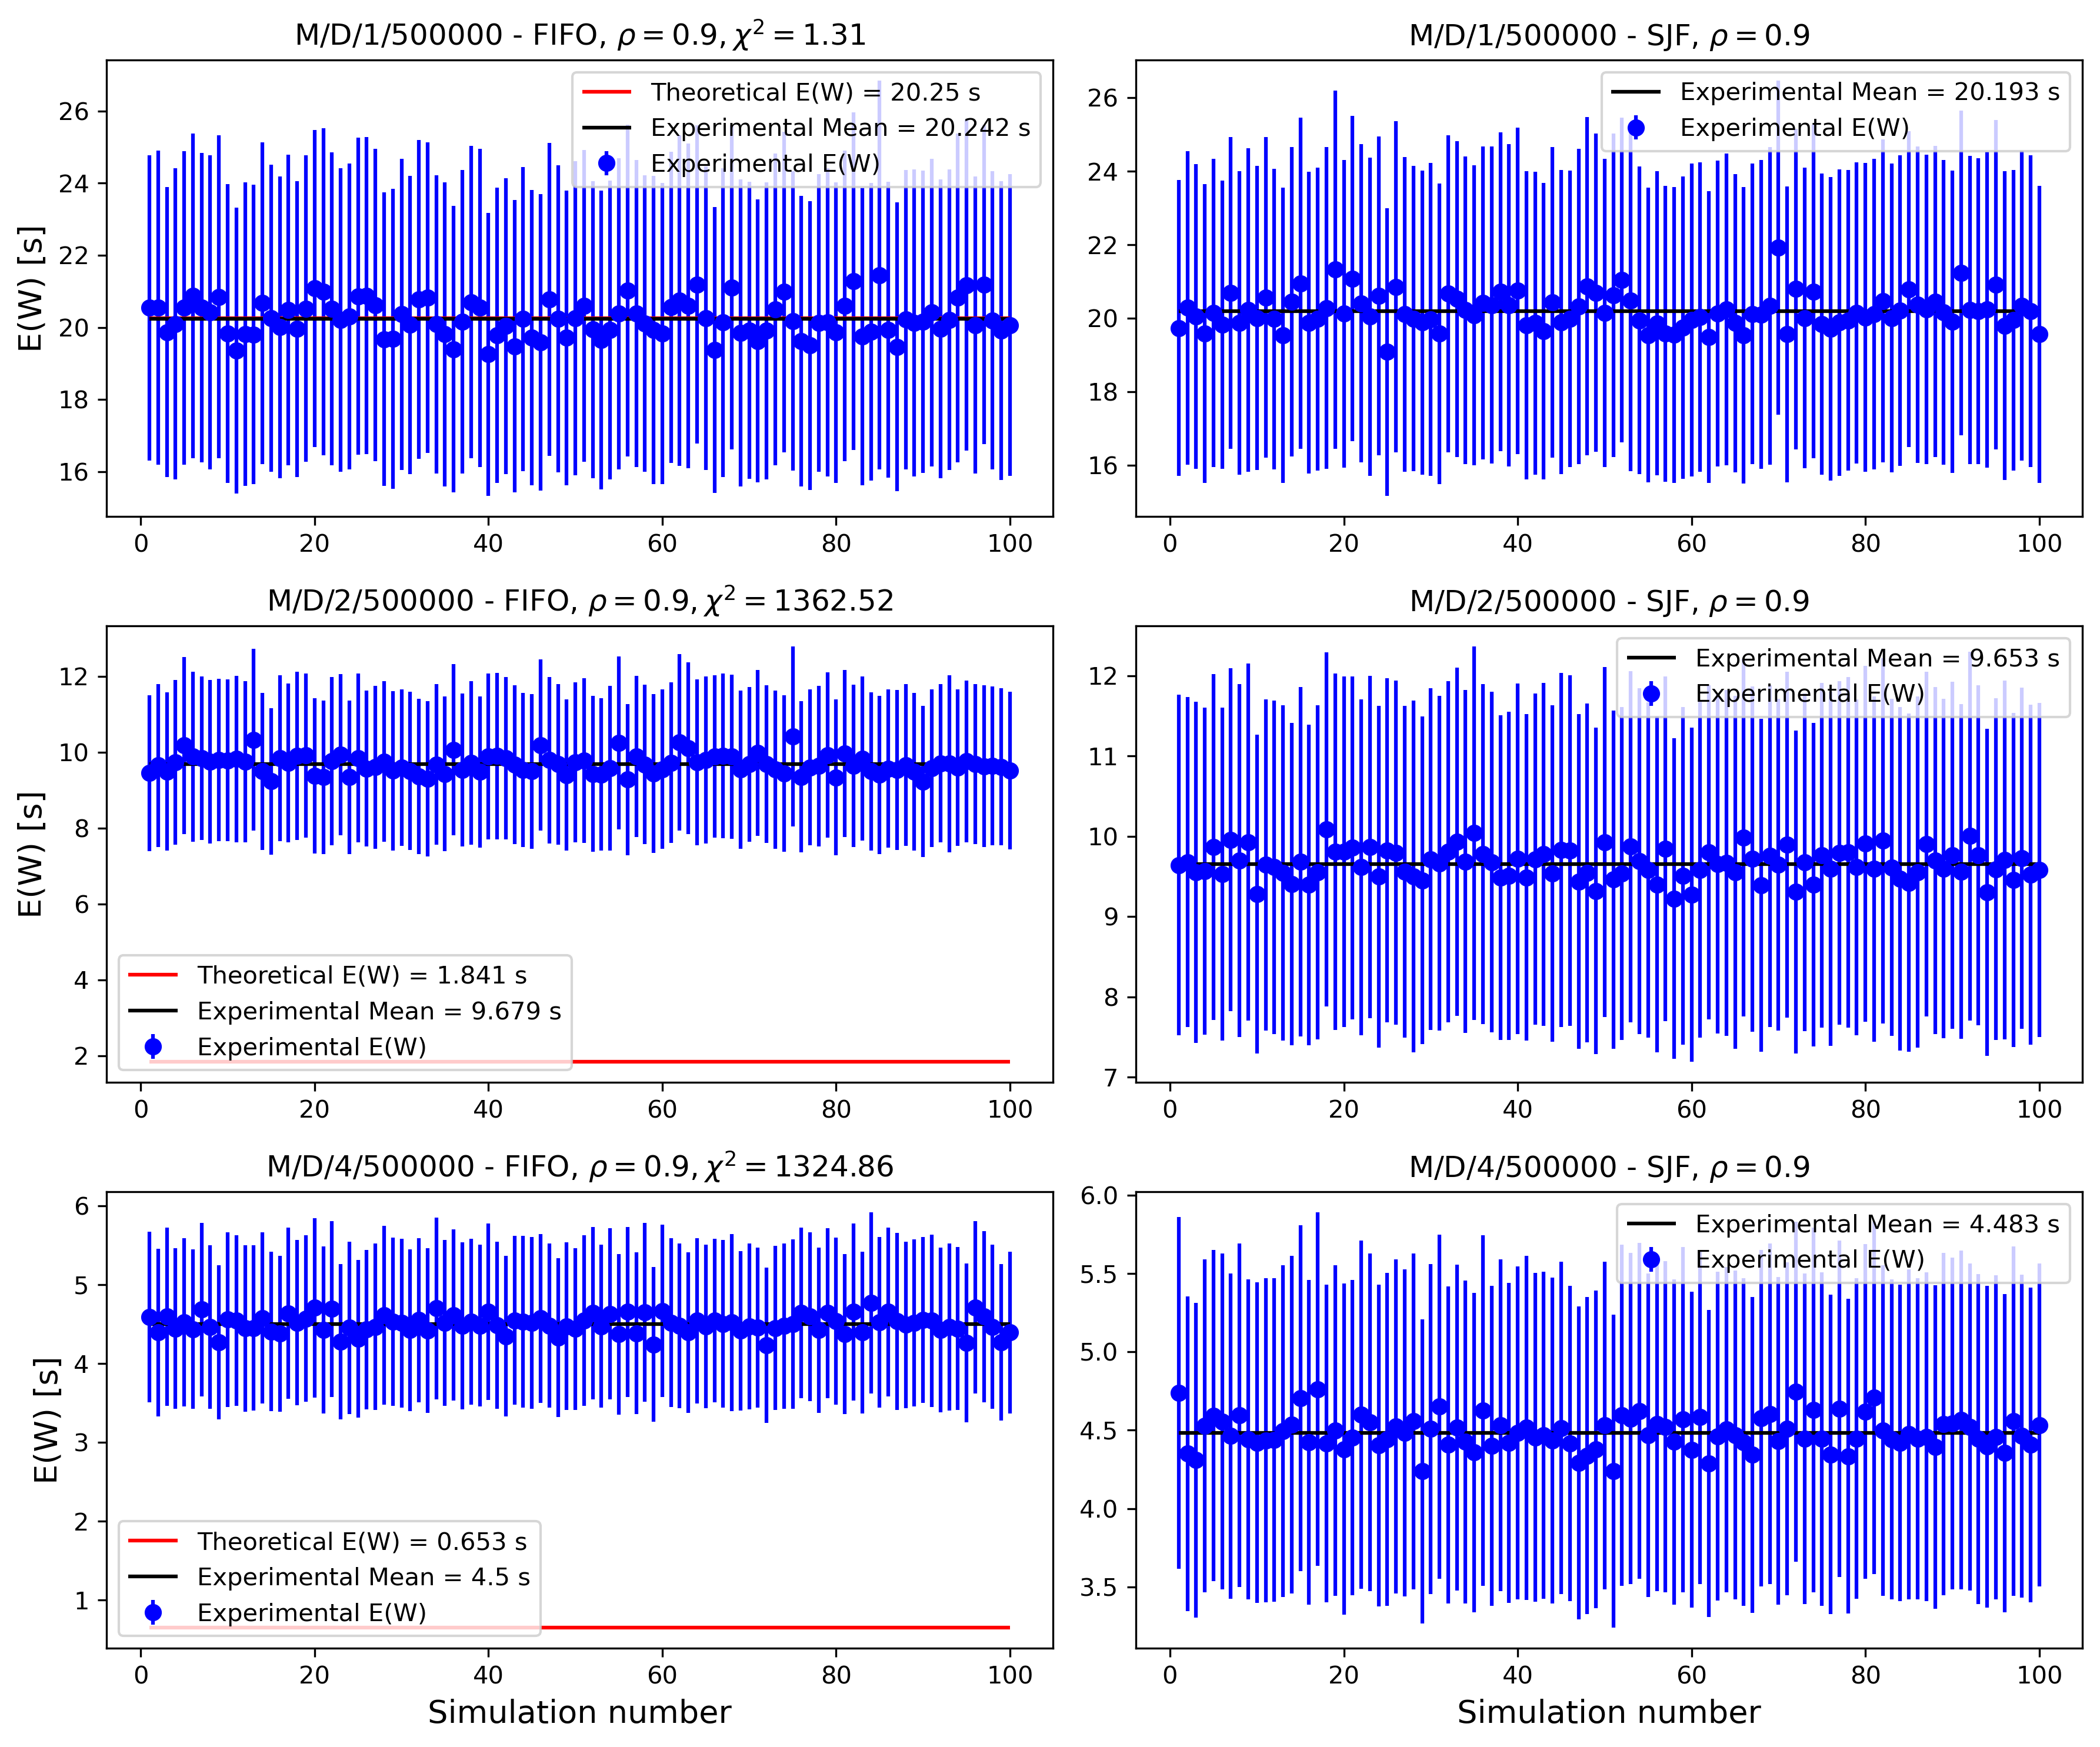

In [39]:
plt.figure(figsize=(12, 10), dpi=300)

plt.subplot(3,2,1)
plt.title(fr'M/D/{num_servers[0]}/{num_requests} - FIFO, $\rho = {{{round(arrival_rate/(num_servers[0]*(1/D)), 2)}}}, \chi^2 = {round(fifo_single_server_stats_det[3], 2)}$')
plt.errorbar(range(1, num_simulations+1), sim_means_fifo_det[0], yerr=fifo_single_server_stats_det[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_single_server_stats_det[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_single_server_stats_det[0], 3)} s')
plt.hlines(fifo_single_server_stats_det[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_single_server_stats_det[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,3)
plt.title(fr'M/D/{num_servers[1]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*(1/D)), 2)}}}, \chi^2 = {round(fifo_two_server_stats_det[3], 2)}$')
plt.errorbar(range(1, num_simulations+1), sim_means_fifo_det[1], yerr=fifo_two_server_stats_det[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_two_server_stats_det[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_two_server_stats_det[0], 3)} s')
plt.hlines(fifo_two_server_stats_det[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_two_server_stats_det[1], 3)} s')
plt.legend()
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,5)
plt.title(fr'M/D/{num_servers[2]}/{num_requests} - FIFO, $\rho = {{{round(num_servers[2]*arrival_rate/(num_servers[2]*(1/D)), 2)}}}, \chi^2 = {round(fifo_four_server_stats_det[3], 2)}$')
plt.errorbar(range(1, num_simulations+1), sim_means_fifo_det[2], yerr=fifo_four_server_stats_det[2], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(fifo_four_server_stats_det[0], xmin=1, xmax=num_simulations, color='red', label=f'Theoretical E(W) = {round(fifo_four_server_stats_det[0], 3)} s')
plt.hlines(fifo_four_server_stats_det[1], xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(fifo_four_server_stats_det[1], 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)
plt.ylabel('E(W) [s]', fontsize=13)

plt.subplot(3,2,2)
plt.title(fr'M/D/{num_servers[0]}/{num_requests} - SJF, $\rho = {{{round(arrival_rate/(num_servers[0]*(1/D)), 2)}}}$')
plt.errorbar(range(1, num_simulations+1), sim_means_sjf_det[0], yerr=sjf_single_conf95_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_single_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_single_server_mean_det, 3)} s')
plt.legend()

plt.subplot(3,2,4)
plt.title(fr'M/D/{num_servers[1]}/{num_requests} - SJF, $\rho = {{{round(num_servers[1]*arrival_rate/(num_servers[1]*(1/D)), 2)}}}$')
plt.errorbar(range(1, num_simulations+1), sim_means_sjf_det[1], yerr=sjf_two_conf95_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_two_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_two_server_mean_det, 3)} s')
plt.legend()

plt.subplot(3,2,6)
plt.title(fr'M/D/{num_servers[2]}/{num_requests} - SJF, $\rho = {{{round(num_servers[2]*arrival_rate/(num_servers[2]*(1/D)), 2)}}}$')
plt.errorbar(range(1, num_simulations+1), sim_means_sjf_det[2], yerr=sjf_four_conf95_det, fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(sjf_four_server_mean_det, xmin=1, xmax=num_simulations, color='black', label=f'Experimental Mean = {round(sjf_four_server_mean_det, 3)} s')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)

plt.tight_layout()
plt.show()